In [1]:
%matplotlib inline
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sophus import *

In [2]:
def get_ellipse(mean, covariance, k2, N=20):
    """
    Computes x and y values given a covariance matrix and chi-squared threshold.
    mean: length-2 mean vector
    covariance: 2x2 covariance matrix
    k2: chi-squared threshold
    N: number of points to compute
    Example:
    mu = zeros (2,)
    covariance = diag([1,2])
    k2 = scipy.stats.chi2.ppf(.999, 2)
    x, y = get_ellipse_2d(mean, covariance, k2)
    """
    
    theta = np.linspace(0, 2. * np.pi, N)
    circle = np.array([np.cos(theta), np.sin(theta)])

    eigs, eigvs = np.linalg.eig((covariance + covariance.T) * 0.5)

    A = eigvs.dot((np.diag(k2*eigs))**.5)
    
    Y = A.dot(circle)
    
    x = mean[0] + Y[0,:].T
    y = mean[1] + Y[1,:].T
    
    return (x, y)

In [3]:
def solve_covariance_dof(centered, inv_sigma, missing_dof, k2):
    """Given a N-dimensional Gaussian and N-1 known values of a sample, solve
    for the missing value.
    centered: length-N vector 'sample - mean'
    inv_sigma: Inverse of the NxN covariance matrix (i.e., the information matrix)
    missing_dof: The vector index we want to solve for.
    k2 = scipy.stats.chi2.ppf(your_desired_percentile, N).

    Example:
    S = np.array([[1.,0.5,-0.2],[0.5,2,0.1],[-0.2, 0.1, 3.]])
    mu = np.array([-1., 1., 3.])
    x = np.array([3., 4., 5.])
    k2 = (x - mu).dot(np.linalg.inv(S)).dot(x - mu)
    solved = solve_covariance_dof(x - mu, np.linalg.inv(S), 1, k2)
    print('solved:', solved)  # Prints 3.0, which is what we expect (i.e., 4 - 1)
    """
    # Solve second order polynomial: (-b^2 +- sqrt(b^2 - 4ac)) / (2a)
    all_dofs = [i for i in range(len(centered))]
    known_dofs = [i for i in all_dofs if i != missing_dof]

    lambda_yy = inv_sigma[np.ix_(known_dofs, known_dofs)]
    lambda_xx = inv_sigma[missing_dof, missing_dof]
    lambda_yx = inv_sigma[np.ix_(known_dofs, [missing_dof])]
        
    y = centered[known_dofs]
    a = lambda_xx
    b = 2. * lambda_yx.flatten().dot(y)
    c = y.dot(lambda_yy).dot(y) - k2
        
    return (-b + np.sqrt(abs(b**2 - 4*a*c))) / (2*a)

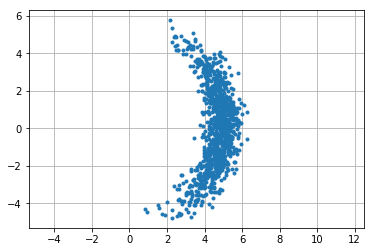

In [4]:
from sophus import *

T_nominal = se2.Se2(so2.So2.exp(0.), Vector2(5., 0.))

error_covariance = np.eye(3)
# Marginals.
error_covariance[0, 0] = 0.2
error_covariance[1, 1] = 0.2
error_covariance[2, 2] = 0.2

# Correlations.
error_covariance[1,2] = 0.06
error_covariance[2,1] = 0.06
error_covariance[0,2] = 0.06
error_covariance[2,0] = 0.06

# error_covariance = randcov(3)

N = 1000
errors = np.random.multivariate_normal(np.zeros(3,), error_covariance, N)
points = np.zeros((2, N))
i = 0
for error in errors:
    T_true = se2.Se2.exp(Vector3(error[0], error[1], error[2])) * T_nominal
    point = np.array([T_true.t[0], T_true.t[1]])
    points[:,i] = point
    i += 1
plt.plot(points[0, :], points[1,:], '.')
plt.axis('equal')
plt.grid(True)



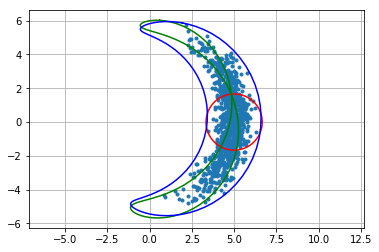

In [5]:
import scipy.stats
k2 = scipy.stats.chi2.ppf(.999, 2)
xy = get_ellipse(np.zeros(2,), error_covariance[np.ix_([0,1], [0,1])], k2, 100)
yt = get_ellipse(np.zeros(2,), error_covariance[np.ix_([1,2], [1,2])], k2, 100)
xt = get_ellipse(np.zeros(2,), error_covariance[np.ix_([0,2], [0,2])], k2, 100)

plt.plot(points[0, :], points[1,:], '.')
plt.axis('equal')
plt.grid(True)

lam = np.linalg.inv(error_covariance)
xy = np.row_stack((xy[0], xy[1]))
fuck = np.zeros((2, 100))
i = 0
for p in xy.T:
    theta = solve_covariance_dof(np.array([p[0], p[1], 0.]), lam, 2, k2)
    e = se2.Se2.exp(Vector3(p[0], p[1], 0.))
    p = (e * T_nominal) * Vector2(0., 0.)
    fuck[:,i] = np.array([p[0], p[1]])
    i += 1
plt.plot(fuck[0,:], fuck[1,:], 'r')

yt = np.row_stack((yt[0], yt[1]))
fuck = np.zeros((2, 100))
i = 0
for p in yt.T:
    x = solve_covariance_dof(np.array([0., p[0], p[1]]), lam, 0, k2)
    e = se2.Se2.exp(Vector3(x, p[0], p[1]))
    p = (e * T_nominal) * Vector2(0., 0.)
    fuck[:,i] = np.array([p[0], p[1]])
    i += 1
plt.plot(fuck[0,:], fuck[1,:], 'g')

xt = np.row_stack((xt[0], xt[1]))
fuck = np.zeros((2, 100))
i = 0
for p in xt.T:
    y = solve_covariance_dof(np.array([p[0], 0., p[1]]), lam, 1, k2)
    e = se2.Se2.exp(Vector3(p[0], y, p[1]))
    p = (e * T_nominal) * Vector2(0., 0.)
    fuck[:,i] = np.array([p[0], p[1]])
    i += 1
plt.plot(fuck[0,:], fuck[1,:], 'b')

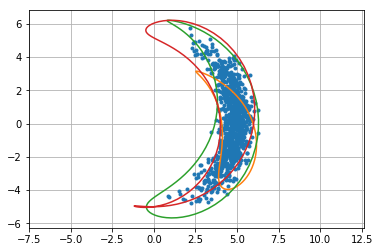

In [6]:
def randcov (n):
    """
    Generates a random, but valid, covariance matrix (size nxn)
    """
    L = scipy.randn(n, n)
    D = np.eye (n)
    return L.T.dot (D).dot (L)
cov = randcov(3)

cov = error_covariance
Lambda, U = scipy.linalg.eig(cov)
Lambda = Lambda.real

plt.plot(points[0, :], points[1,:], '.')
plt.axis('equal')
plt.grid(True)
# basis2d_0 = U[:, [0, 1]]
# basis2d_1 = U[:, [1, 2]]
# basis2d_2 = U[:, [0, 2]]
# print(basis2d_0)

# print('U', U)
# print('Lambda', Lambda)

eigs_0 = Lambda[[0, 1]]
eigs_1 = Lambda[[1, 2]]
eigs_2 = Lambda[[0, 2]]

axis_aligned_2d = np.diag(eigs_0)
x, y = get_ellipse(np.zeros(2,), axis_aligned_2d, k2, 100)
xyz = np.row_stack((x, y, np.zeros(len(x),)))
Unew = np.zeros((3,3))
Unew[:,0] = U[:,0]
Unew[:,1] = U[:,1]
Unew[:,2] = np.cross(Unew[:,0], Unew[:,1])

ellipse = Unew.dot(xyz)
contour_points = np.zeros((2, len(x),))
for i in range(len(x)):
    p = ellipse[:, i]
    e = se2.Se2.exp(Vector3(p[0], p[1], p[2]))
    tmp = (e * T_nominal).t
    contour_points[:,i] = np.array([tmp[0], tmp[1]])
plt.plot(contour_points[0,:], contour_points[1,:])

axis_aligned_2d = np.diag(eigs_1)
x, y = get_ellipse(np.zeros(2,), axis_aligned_2d, k2, 100)
xyz = np.row_stack((x, y, np.zeros(len(x),)))
Unew = np.zeros((3,3))
Unew[:,0] = U[:,1]
Unew[:,1] = U[:,2]
Unew[:,2] = np.cross(Unew[:,0], Unew[:,1])

ellipse = Unew.dot(xyz)
contour_points = np.zeros((2, len(x),))
for i in range(len(x)):
    p = ellipse[:, i]
    e = se2.Se2.exp(Vector3(p[0], p[1], p[2]))
    tmp = (e * T_nominal).t
    contour_points[:,i] = np.array([tmp[0], tmp[1]])
plt.plot(contour_points[0,:], contour_points[1,:])

axis_aligned_2d = np.diag(eigs_2)
x, y = get_ellipse(np.zeros(2,), axis_aligned_2d, k2, 100)
xyz = np.row_stack((x, y, np.zeros(len(x),)))
Unew = np.zeros((3,3))
Unew[:,0] = U[:,0]
Unew[:,1] = U[:,2]
Unew[:,2] = np.cross(Unew[:,0], Unew[:,1])

ellipse = Unew.dot(xyz)
contour_points = np.zeros((2, len(x),))
for i in range(len(x)):
    p = ellipse[:, i]
    e = se2.Se2.exp(Vector3(p[0], p[1], p[2]))
    tmp = (e * T_nominal).t
    contour_points[:,i] = np.array([tmp[0], tmp[1]])
plt.plot(contour_points[0,:], contour_points[1,:])



In [7]:
error_covariance

array([[0.2 , 0.  , 0.06],
       [0.  , 0.2 , 0.06],
       [0.06, 0.06, 0.2 ]])

(-1.5643063643570905, 6.968114621632675, -6.46257367245672, 6.834674161415931)

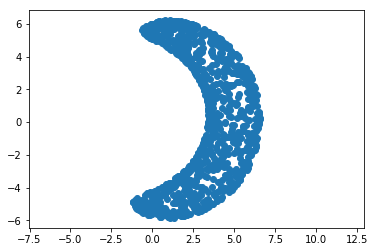

In [8]:
# Generate uniformally-spaced points on a 3D sphere (extends to any dimension).
N = 1000
pts_on_sphere = np.zeros((3,N))
for i in range(N):
    x = np.random.normal(size=3,)
    pt = x / np.linalg.norm(x)
    pts_on_sphere[:,i] = pt
# plt.scatter(pts[0,:], pts[1,:])
# plt.axis('equal')

covariance = error_covariance
eigs, eigvs = np.linalg.eig((covariance + covariance.T) * 0.5)
k2 = scipy.stats.chi2.ppf(.999, 2)
A = eigvs.dot((np.diag(k2*eigs))**.5)
Y = A.dot(pts_on_sphere)
    
contour_points = np.zeros((2, N))
for i in range(N):
    p = Y[:, i]
    e = se2.Se2.exp(Vector3(p[0], p[1], p[2]))
    tmp = (e * T_nominal).t
    contour_points[:,i] = np.array([tmp[0], tmp[1]])
plt.scatter(contour_points[0,:], contour_points[1,:])
plt.axis('equal')

# TODO: add convex hull over these points


(-1.525041812468923, 6.903056416816701, -6.403531476531751, 6.783936536147447)

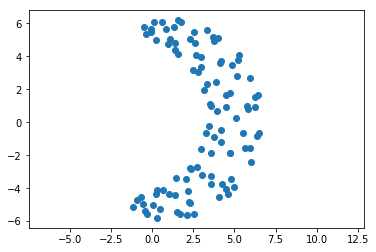

In [17]:
import math
# Generate evenly distributed, non-random points on a sphere
def fibonacci_sphere(samples=1):
    rnd = 1.

    points = []
    offset = 2./samples
    increment = math.pi * (3. - math.sqrt(5.));

    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = math.sqrt(1 - pow(y,2))

        phi = ((i + rnd) % samples) * increment

        x = math.cos(phi) * r
        z = math.sin(phi) * r

        points.append([x,y,z])

    return points
N = 100
pts_on_sphere = np.array(fibonacci_sphere(N)).T

covariance = error_covariance
eigs, eigvs = np.linalg.eig((covariance + covariance.T) * 0.5)
k2 = scipy.stats.chi2.ppf(.999, 2)
A = eigvs.dot((np.diag(k2*eigs))**.5)
Y = A.dot(pts_on_sphere)
    
contour_points = np.zeros((2, N))
for i in range(N):
    p = Y[:, i]
    e = se2.Se2.exp(Vector3(p[0], p[1], p[2]))
    tmp = (e * T_nominal).t
    contour_points[:,i] = np.array([tmp[0], tmp[1]])
plt.scatter(contour_points[0,:], contour_points[1,:])
plt.axis('equal')
